<a href="https://colab.research.google.com/github/winirrr/Thai-qoute-generator/blob/main/model/finetuned_model_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/huggingface/transformers -q peft  accelerate bitsandbytes safetensors sentencepiece datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset

## Prepare Model for Training

In [ ]:
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

In [ ]:
model = AutoModelForCausalLM.from_pretrained("scb10x/typhoon-7b", quantization_config=bnb_config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.57G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("scb10x/typhoon-7b",
                                          model_max_length=512,
                                          padding_side="left",
                                          add_eos_token=True)

tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/915 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/563k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.99M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(35219, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model,config)

In [ ]:
model.print_trainable_parameters()

trainable params: 21,286,040 || all params: 7,289,388,184 || trainable%: 0.29201408215194596


## Prepare Training Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
dataset = load_dataset("text", data_files="https://raw.githubusercontent.com/winirrr/Thai-qoute-generator/main/quote_data/300_small_th_quote.txt", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['text'],
    num_rows: 300
})

In [ ]:
len(dataset)

300

In [ ]:
train_dataset = dataset
eval_dataset = dataset.shuffle(seed=42).select(range(int(len(dataset)*0.1)))

In [ ]:
train_dataset

Dataset({
    features: ['text'],
    num_rows: 300
})

In [ ]:
eval_dataset

Dataset({
    features: ['text'],
    num_rows: 30
})

In [ ]:
tk_data_1 = tokenizer(train_dataset['text'], padding=True, truncation=True, return_tensors='pt')
tk_data_2 = tokenizer(eval_dataset['text'], padding=True, truncation=True, return_tensors='pt')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.input_ids = data['input_ids']
        self.attention_mask = data['attention_mask']
        self.labels = data['input_ids']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels':self.labels[idx]
        }

train_data = CustomDataset(tk_data_1)
eval_data = CustomDataset(tk_data_2)

## Fine-tuning the Model

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

In [ ]:
import transformers

In [ ]:
output_dir = './typhoon-7b-quote-demo'

# hyperparameters
lr = 2e-4
batch_size = 1
num_epochs = 50

# define training arguments
training_args = TrainingArguments(
    output_dir= output_dir,
    learning_rate=lr,
    max_steps=1000,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=4,
    warmup_steps=1,
    fp16=True,
    optim="paged_adamw_8bit",
    do_eval=True,
)

model.config.use_cache = False

trainer = Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
import warnings

# Filter out the specific warning about torch.utils.checkpoint
warnings.filterwarnings("ignore", message="torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly.*")

# Your code here


# Start training
trainer.train()

Epoch,Training Loss,Validation Loss
1,3.078700,1.835066
2,1.601600,0.821162
3,0.815500,0.611438
4,0.680100,0.526003
5,0.590600,0.486123
6,0.542700,0.474480
7,0.509600,0.425188
8,0.466100,0.368820
9,0.433400,0.357289
10,0.412100,0.362474


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

TrainOutput(global_step=1000, training_loss=0.7795685272216797, metrics={'train_runtime': 6271.5623, 'train_samples_per_second': 0.638, 'train_steps_per_second': 0.159, 'total_flos': 4801528139520000.0, 'train_loss': 0.7795685272216797, 'epoch': 13.33})

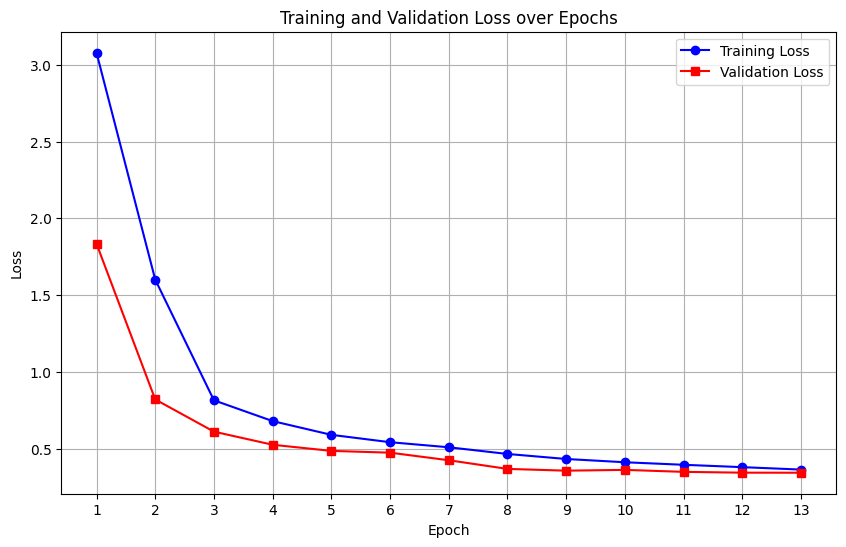

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(epoch_list, training_losses, validation_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, training_losses, label='Training Loss', marker='o', color='b')
    plt.plot(epoch_list, validation_losses, label='Validation Loss', marker='s', color='r')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epoch_list)  # Set x-axis ticks to be the epoch numbers
    plt.legend()
    plt.grid(True)
    plt.show()

# Sample data for the second set
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
training_losses = [3.0787, 1.6016, 0.8155, 0.6801, 0.5906, 0.5427, 0.5096, 0.4661, 0.4334, 0.4121, 0.3956, 0.3802, 0.3644]
validation_losses = [1.835066, 0.821162, 0.611438, 0.526003, 0.486123, 0.47448, 0.425188, 0.36882, 0.357289, 0.362474, 0.349547, 0.344284, 0.343944]

# Call the function to plot
plot_losses(epochs, training_losses, validation_losses)


In [ ]:
model.config.use_cache = True

## Inference

In [ ]:
prompt = "ไม่รู้"

inputs = tokenizer(prompt, return_tensors="pt")

model.eval()
with torch.inference_mode():
 outputs = model.generate(**inputs, penalty_alpha=0.6, top_k=4)
 print(tokenizer.batch_decode(outputs, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


['ไม่รู้ ถ้าไม่นับเงินในกระเป๋า เราดีกว่าเขาเเน่นอน เพราะมี']


## Push our model into hugging face

In [ ]:
model.save_pretrained("output_dir")

In [ ]:
print(output_dir)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()
model.push_to_hub("winirrr/typhoon-7b-quote-demoV00")

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


adapter_model.safetensors:   0%|          | 0.00/662M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/winirrr/typhoon-7b-quote-demoV00/commit/78129fec0c4d8118d31277f6ddf5f7d4848eef9c', commit_message='Upload model', commit_description='', oid='78129fec0c4d8118d31277f6ddf5f7d4848eef9c', pr_url=None, pr_revision=None, pr_num=None)